# Simple-Q

* InfoGAN-simplified 버전에서 Q-encoder 를 따로 떼어보자.
* Q 는 c 를 잘 만들면 된다.
* 이렇게 하면 비로소 DiscoGAN-(b) 형태가 됨. (GAN with reconstruction model)

![discogan_models](models_discogan.png)

* Common points
    * 위 그림은 DiscoGAN 의 그림으로, 여기서 (b) 가 InfoGAN 에 가까움.
    * G_BA 가 InfoGAN 의 encoder Q 에 해당하며, InfoGAN 에서는 D 와 네트워크를 일정 부분 쉐어함
        * Q를 학습할 때 따로 하지 않고 D_loss + Q_loss 로 한꺼번에 학습
        * 따로 해도 별 문제는 없을 듯
        * 어차피 로스를 더해주므로, shared_net 은 두번 학습되는것과 마찬가지임.
* Difference points
    * InfoGAN 이 훨씬 더 수학적 이론에 근거한 principled way 라고 할 수 있음
    * 다만, DiscoGAN 에 따르면 Cycle-consistency (c) 를 사용하지 않을 경우 문제가 발생할 수 있다고 하는데 InfoGAN 에서는 왜 그러한 문제가 발생하지 않는지 알 수 없음

## ToDo

* 잘 모르겠으니 DiscoGAN 방식으로 한번 구현해보자.
* InfoGAN 에 적용했을 때 어떻게 되는지.

### Conclusion

* 잘 됨! (lr 2 배로 조정 - for shared nets. 조정 안해도 될지도 모름)
* 다만 이게 DiscoGAN 방식인지는 모르겠다. DiscoGAN 을 구현해보자.

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
import sys
sys.path.insert(0, '../')
from utils import *

In [3]:
slim = tf.contrib.slim

In [4]:
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# 사실 이 세팅은 # of disc r.v. = 1 이라고 가정한 것
c_disc_dim = 10
c_cont_dim = 2
c_dim = c_disc_dim + c_cont_dim

In [6]:
def lrelu(x, leak=0.1, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
def generator(z, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d_transpose], 
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params,
                            activation_fn=tf.nn.relu):
            net = z
            net = slim.fully_connected(net, 1024)
            net = slim.fully_connected(net, 7*7*128)
            net = tf.reshape(net, [-1, 7, 7, 128])
            net = slim.conv2d_transpose(net, 64, [4,4], stride=2)
            net = slim.conv2d_transpose(net, 1, [4,4], stride=2, activation_fn=tf.nn.sigmoid, normalizer_fn=None)
            expected_shape(net, [None, 28, 28, 1])
            
            return net

In [8]:
def discriminator(x, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d],
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params,
                            activation_fn=lrelu):
            net = tf.reshape(x, [-1, 28, 28, 1])
            net = slim.conv2d(net, 64, [4,4], stride=2, normalizer_fn=None)
            net = slim.conv2d(net, 128, [4,4], stride=2)
            net = slim.flatten(net)
            net = slim.fully_connected(net, 1024)
            d_logits = slim.fully_connected(net, 1, activation_fn=None, normalizer_fn=None)
            expected_shape(d_logits, [None, 1])
            
            return d_logits

In [9]:
def encoder(x, reuse=False):
    with tf.variable_scope("encoder", reuse=reuse):
        with slim.arg_scope([slim.fully_connected, slim.conv2d],
                            normalizer_fn=slim.batch_norm, normalizer_params=bn_params,
                            activation_fn=lrelu):
            net = tf.reshape(x, [-1, 28, 28, 1])
            net = slim.conv2d(net, 64, [4,4], stride=2, normalizer_fn=None)
            net = slim.conv2d(net, 128, [4,4], stride=2)
            net = slim.flatten(net)
            net = slim.fully_connected(net, 1024)
            q_net = slim.fully_connected(net, 128)
            q_logits = slim.fully_connected(q_net, c_dim, activation_fn=None, normalizer_fn=None)
            expected_shape(q_logits, [None, c_dim])
            
            return q_logits

In [10]:
# for tf.losses module: this module emits INFO level logs (but does not informative)
tf.logging.set_verbosity(tf.logging.ERROR)

In [11]:
# build nets
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
training = tf.placeholder(tf.bool)
z = tf.placeholder(tf.float32, [None, 62])
c = tf.placeholder(tf.float32, [None, c_dim])
c_disc, c_cont = tf.split(c, [c_disc_dim, c_cont_dim], axis=1)

# BN 다음 activ fn 이 linear (lrelu/relu) 이므로 사실 scale 은 false 여도 된다.
bn_params = {
    'is_training': training, # global placeholder training
    'scale': True, 
    'decay': 0.99
}

zc = tf.concat([z, c], axis=1)

G_sample = generator(zc)
D_real_logits = discriminator(X)
D_fake_logits = discriminator(G_sample, reuse=True)
c_fake_logits = encoder(G_sample)
c_fake_logits_disc, c_fake_logits_cont = tf.split(c_fake_logits, [c_disc_dim, c_cont_dim], axis=1)

D_loss_real = tf.losses.sigmoid_cross_entropy(tf.ones_like(D_real_logits), D_real_logits, scope='D_loss/real')
D_loss_fake = tf.losses.sigmoid_cross_entropy(tf.zeros_like(D_fake_logits), D_fake_logits, scope='D_loss/fake')
D_loss = D_loss_real + D_loss_fake

G_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(D_fake_logits), D_fake_logits, scope='G_loss')

Q_loss_disc = tf.losses.softmax_cross_entropy(c_disc, c_fake_logits_disc, scope='Q_loss/disc')
c_fake_probs_cont = tf.nn.sigmoid(c_fake_logits_cont)
Q_loss_cont = tf.losses.mean_squared_error(c_cont, c_fake_probs_cont, scope='Q_loss/cont')
Q_loss = Q_loss_disc + Q_loss_cont

# G 는 생성할 때 Q 를 고려해서 생성하는게 좋겠지.
# Q 는 G 를 고려할 수 없음
# 이걸 고려하지 않으니 전혀 latent code c 를 포착하지 못함
# 당연한가...
G_loss += Q_loss

D_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
G_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
Q_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='encoder')
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='encoder')
with tf.control_dependencies(G_update_ops):
    G_train_op = tf.train.AdamOptimizer(learning_rate=0.005, beta1=0.5).minimize(G_loss, var_list=G_vars)
with tf.control_dependencies(D_update_ops):
    D_train_op = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(D_loss, var_list=D_vars)
with tf.control_dependencies(Q_update_ops):
    Q_train_op = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(Q_loss, var_list=Q_vars)

tf.summary.scalar('D_loss', D_loss)
tf.summary.scalar('D_loss/real', D_loss_real)
tf.summary.scalar('D_loss/fake', D_loss_fake)
tf.summary.scalar('G_loss', G_loss)
tf.summary.scalar('Q_loss', Q_loss)

summary_op = tf.summary.merge_all()

print("build network done ...")

build network done ...


In [12]:
# 62 / 10 / 2

def sample_z(n):
#     return np.random.randn(n, 62) # standard normal dist
    return np.random.uniform(-1, 1, [n, 62]) # uniform

def sample_c_disc(n):
    return np.random.multinomial(1, [1./c_disc_dim]*c_disc_dim, size=n)

def sample_c_cont(n):
    return np.random.uniform(-1, 1, [n, c_cont_dim])

def sample_c(n):
    return np.concatenate([sample_c_disc(n), sample_c_cont(n)], axis=1)

In [13]:
def plot_100(c_cont=np.zeros([100, c_cont_dim])):
    n = 100
    z_ = sample_z(n)
    c1_ = np.zeros([n, c_disc_dim])
    idx = np.arange(n) / int(n**0.5)
    c1_[range(n), idx] = 1
    c_ = np.concatenate([c1_, c_cont], axis=1)
    samples = sess.run(G_sample, {z: z_, c: c_, training: False})
    fig = plot(samples, 10)
    plt.show()

In [14]:
def plot_c1():
    z_ = sample_z(16)
    # c1 을 이렇게 줘야 같은 c1 다른 noise z_ 에 대해서 동일한 샘플을 생성하는지 알 수 있음
    idx = np.random.randint(0, 10)
    c1_ = np.zeros([16, 10])
    c1_[range(16), idx] = 1
    c23_ = sample_c_cont(16)
    c_ = np.concatenate([c1_, c23_], axis=1)
    samples = sess.run(G_sample, {z: z_, c: c_, training: False})
    fig = plot(samples)
    plt.show()

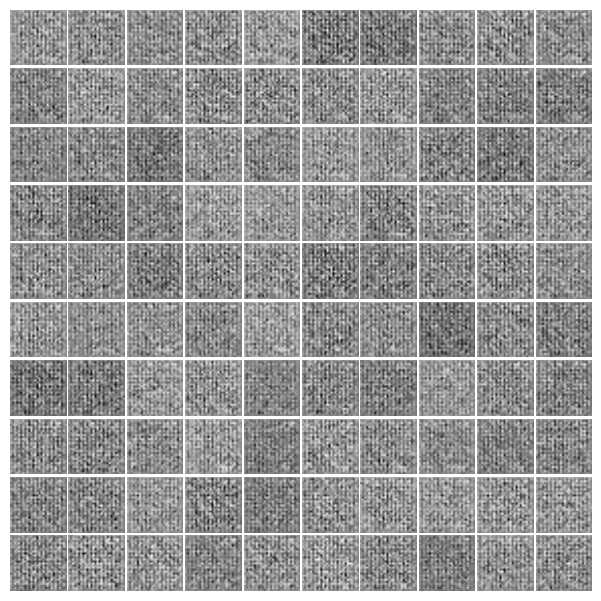

[1/30000] D_loss: 1.5506 | G_loss: 3.9367 | Q_loss: 3.2570


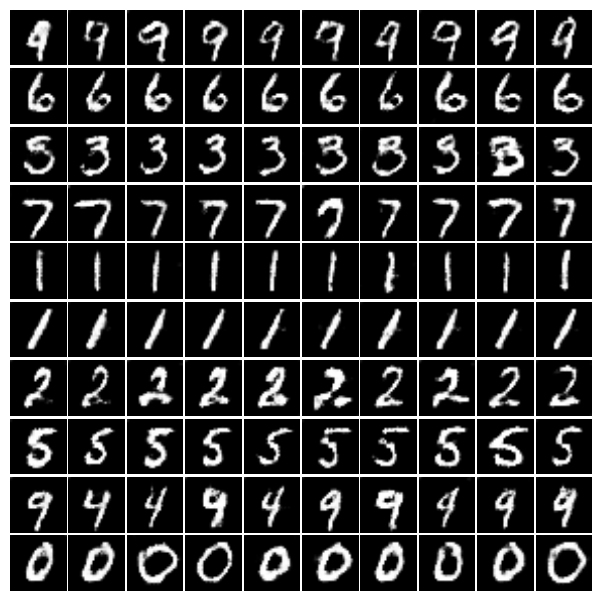

[1001/30000] D_loss: 1.2774 | G_loss: 0.9956 | Q_loss: 0.1733


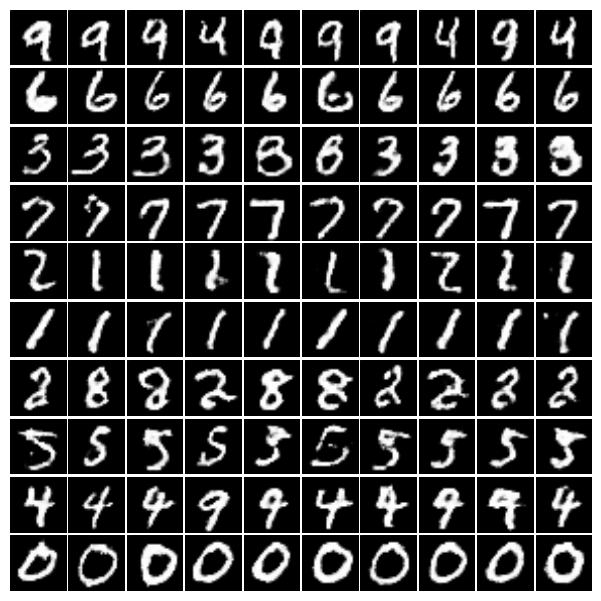

[2001/30000] D_loss: 1.2890 | G_loss: 0.9336 | Q_loss: 0.1594


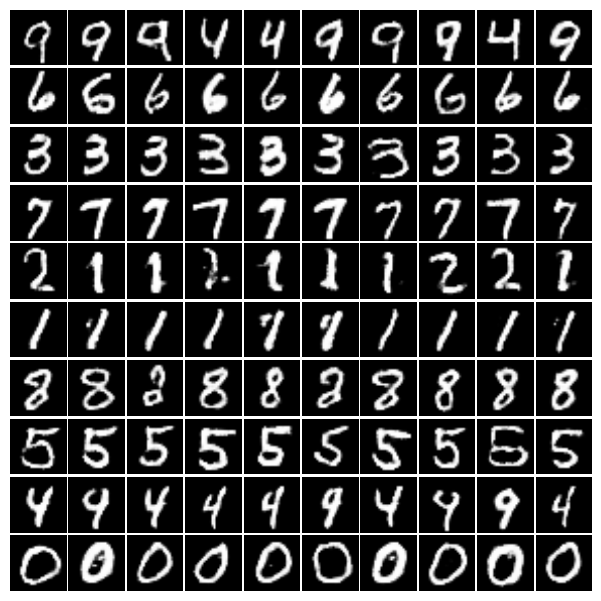

[3001/30000] D_loss: 1.1827 | G_loss: 1.1195 | Q_loss: 0.2360


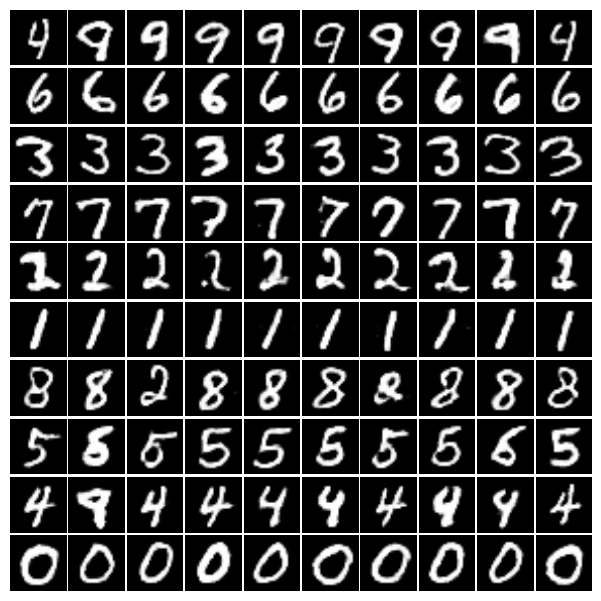

[4001/30000] D_loss: 1.2221 | G_loss: 1.1442 | Q_loss: 0.1570


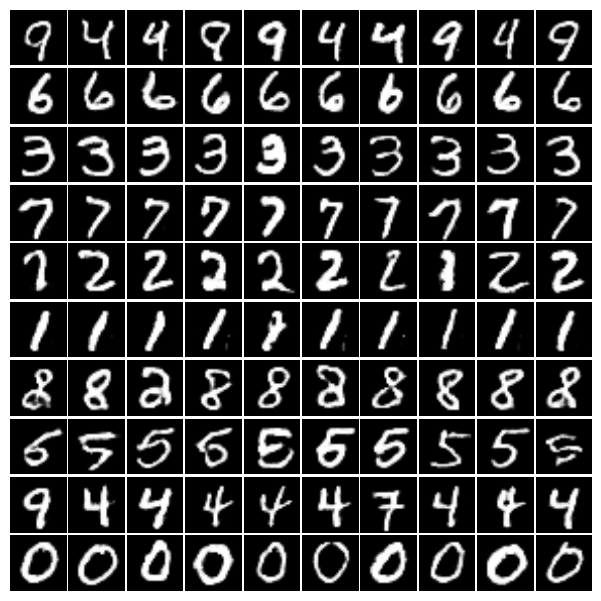

[5001/30000] D_loss: 1.1091 | G_loss: 1.1784 | Q_loss: 0.1715


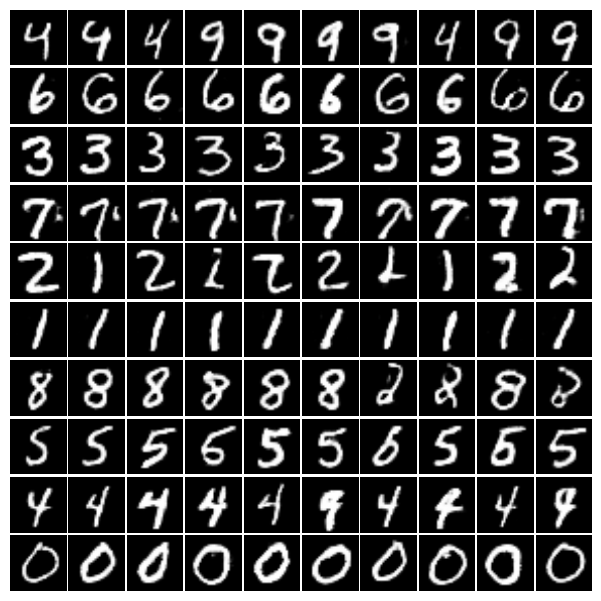

[6001/30000] D_loss: 0.9456 | G_loss: 1.3692 | Q_loss: 0.1812


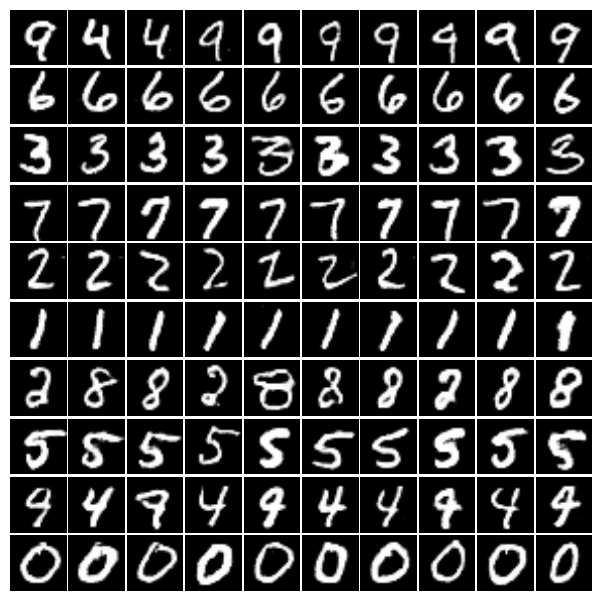

[7001/30000] D_loss: 0.9589 | G_loss: 1.1656 | Q_loss: 0.1800


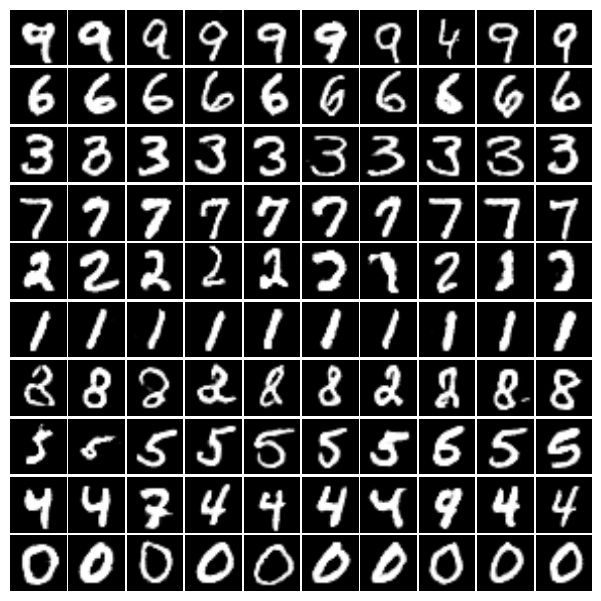

[8001/30000] D_loss: 0.8990 | G_loss: 1.5432 | Q_loss: 0.1633


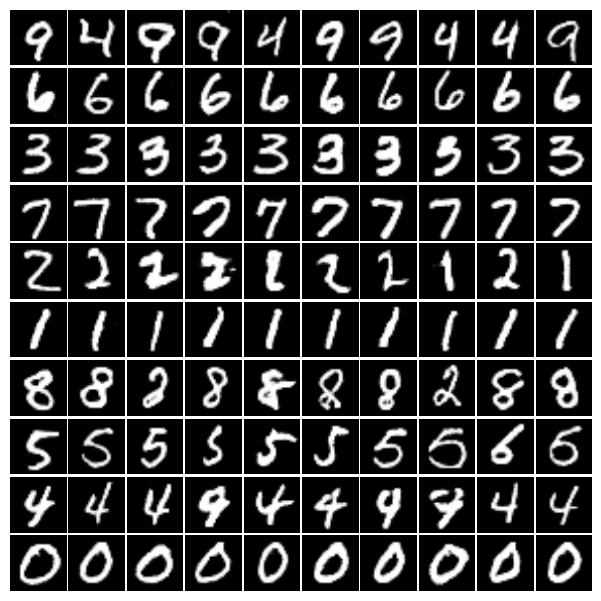

[9001/30000] D_loss: 0.8647 | G_loss: 1.8304 | Q_loss: 0.2204


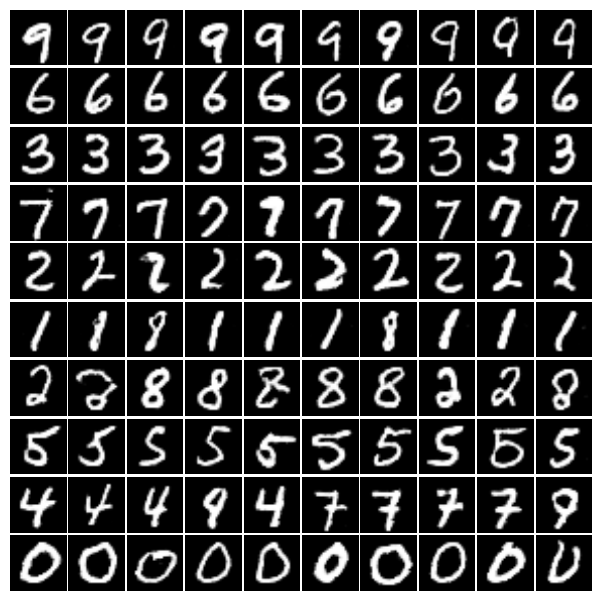

[10001/30000] D_loss: 0.7000 | G_loss: 1.4922 | Q_loss: 0.1742


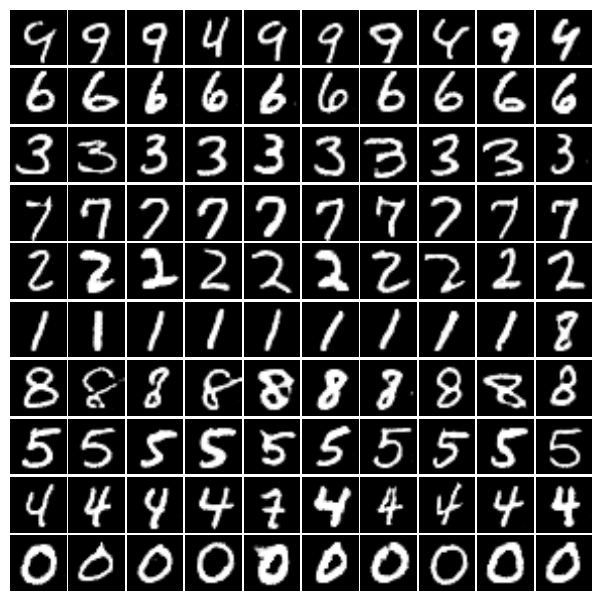

[11001/30000] D_loss: 0.7150 | G_loss: 2.0984 | Q_loss: 0.2306


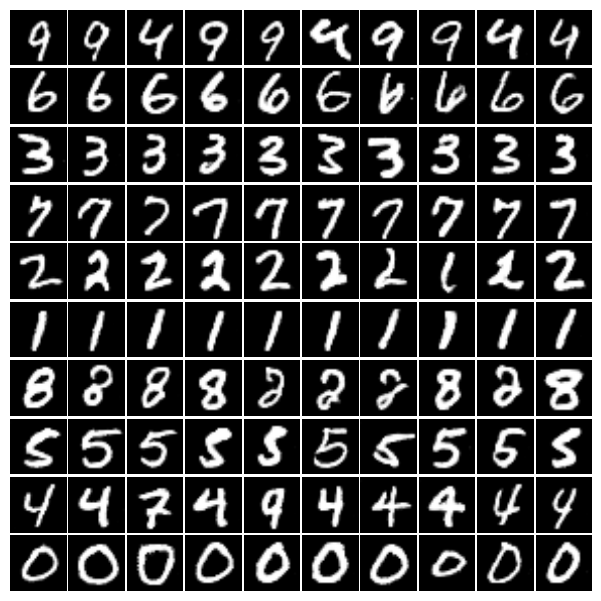

[12001/30000] D_loss: 0.7170 | G_loss: 1.6213 | Q_loss: 0.1773


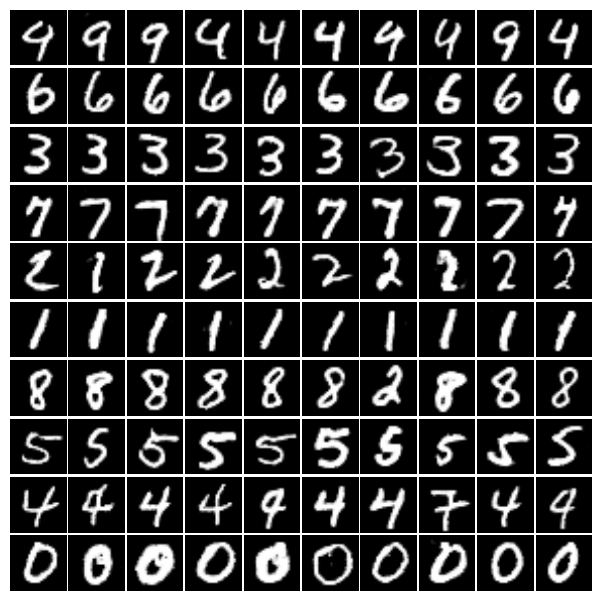

[13001/30000] D_loss: 0.5915 | G_loss: 1.9090 | Q_loss: 0.2024


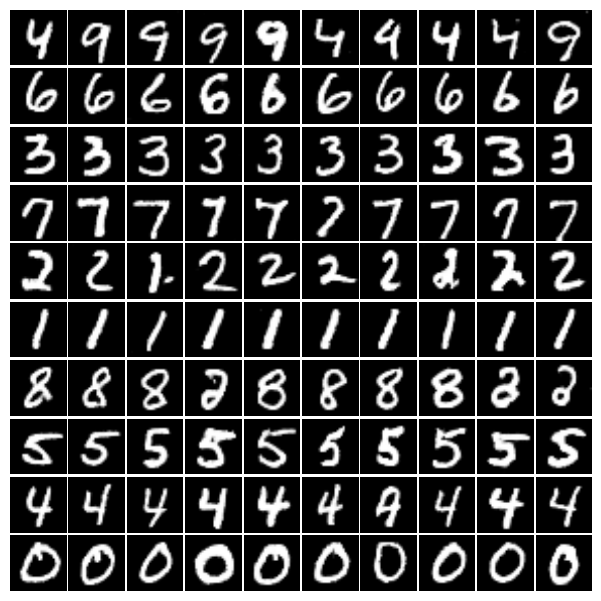

[14001/30000] D_loss: 0.5910 | G_loss: 2.1452 | Q_loss: 0.1984


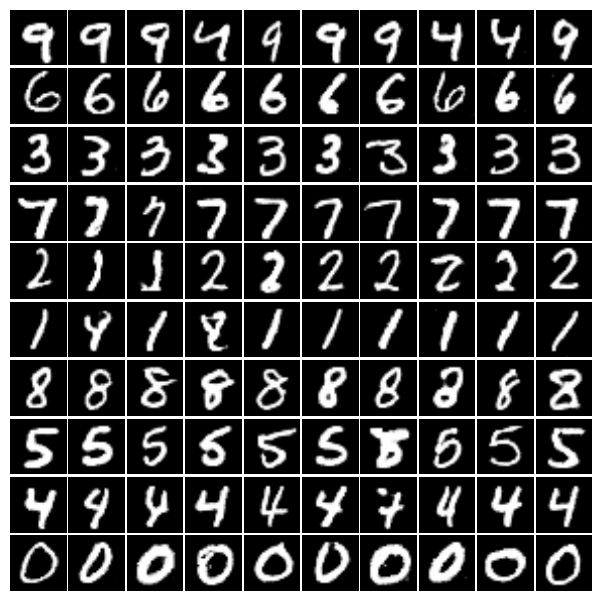

[15001/30000] D_loss: 0.5958 | G_loss: 2.0560 | Q_loss: 0.1412


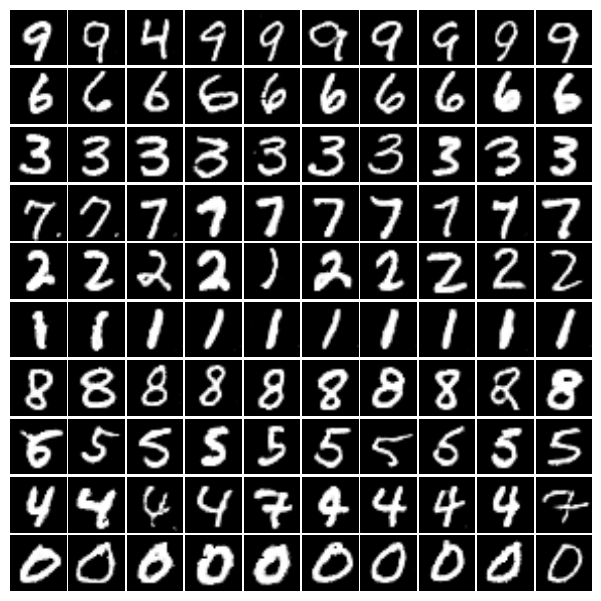

[16001/30000] D_loss: 0.5859 | G_loss: 2.2824 | Q_loss: 0.1808


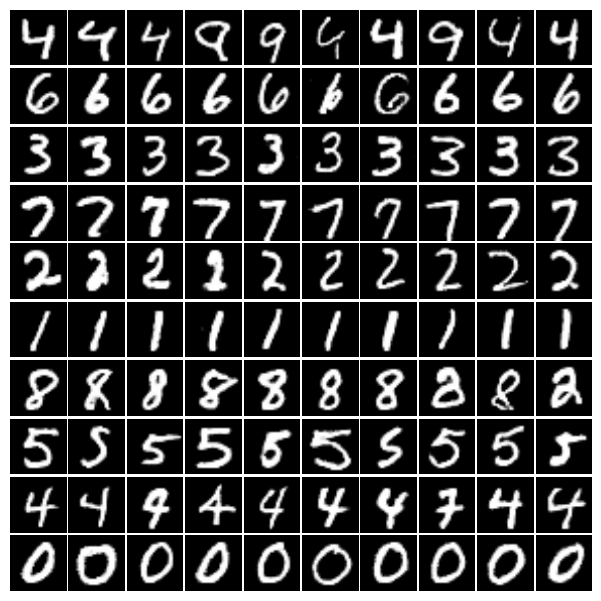

[17001/30000] D_loss: 0.5345 | G_loss: 2.5556 | Q_loss: 0.2418


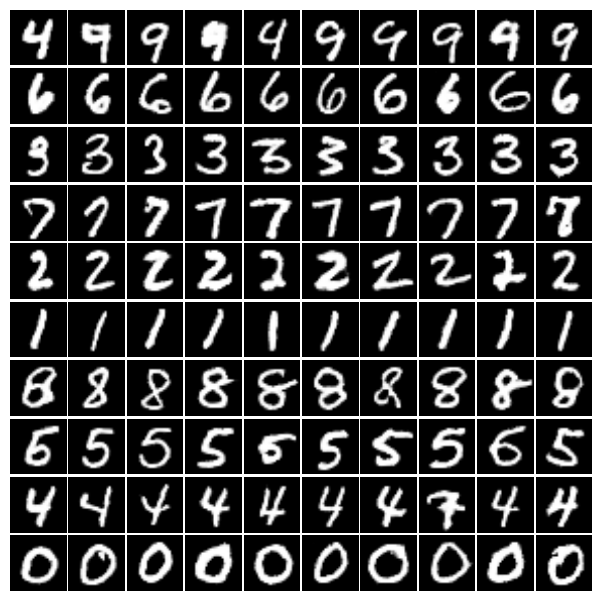

[18001/30000] D_loss: 0.4568 | G_loss: 2.4544 | Q_loss: 0.1939


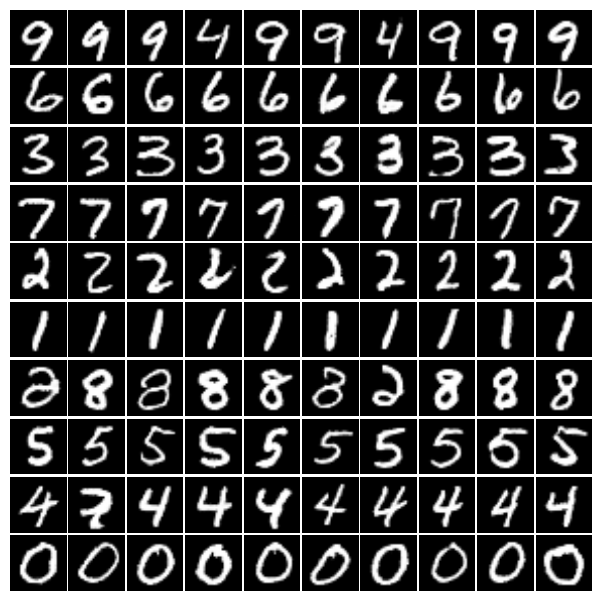

[19001/30000] D_loss: 0.5406 | G_loss: 2.2134 | Q_loss: 0.1810


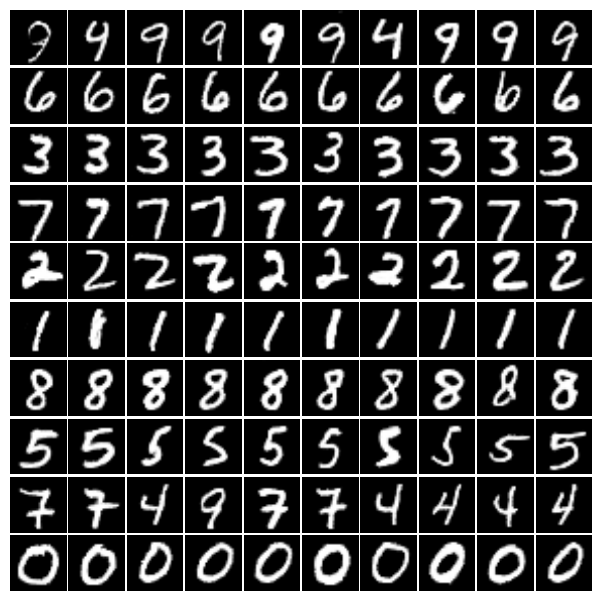

[20001/30000] D_loss: 0.4052 | G_loss: 2.9407 | Q_loss: 0.1834


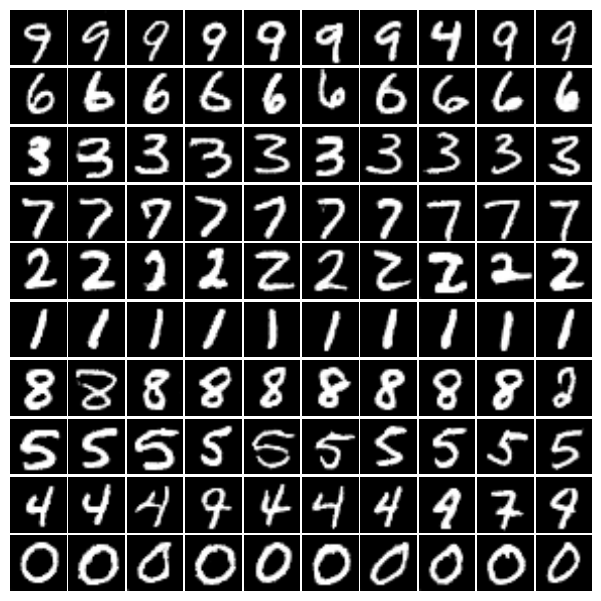

[21001/30000] D_loss: 0.3824 | G_loss: 3.7913 | Q_loss: 0.1639


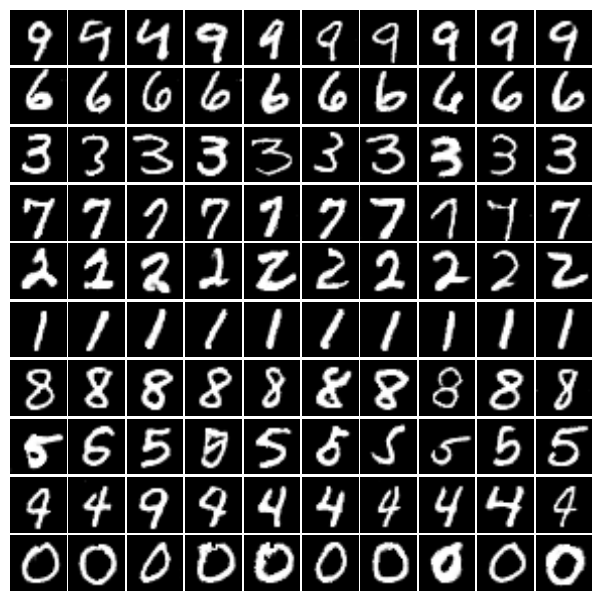

[22001/30000] D_loss: 0.4629 | G_loss: 2.3547 | Q_loss: 0.1740


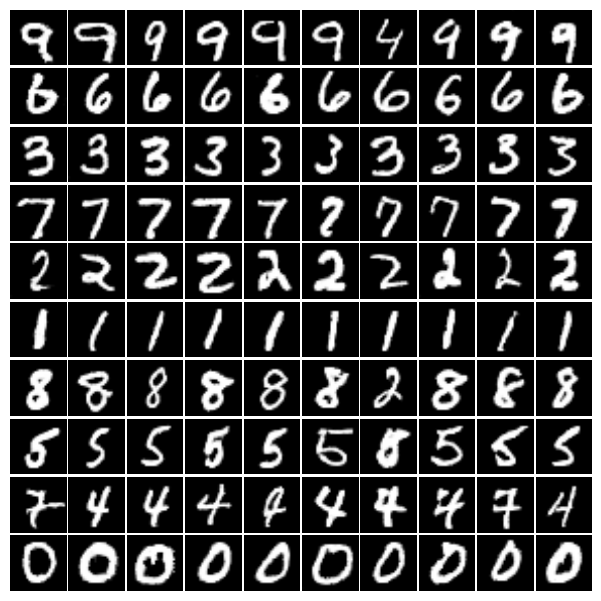

[23001/30000] D_loss: 0.3919 | G_loss: 2.8322 | Q_loss: 0.1870


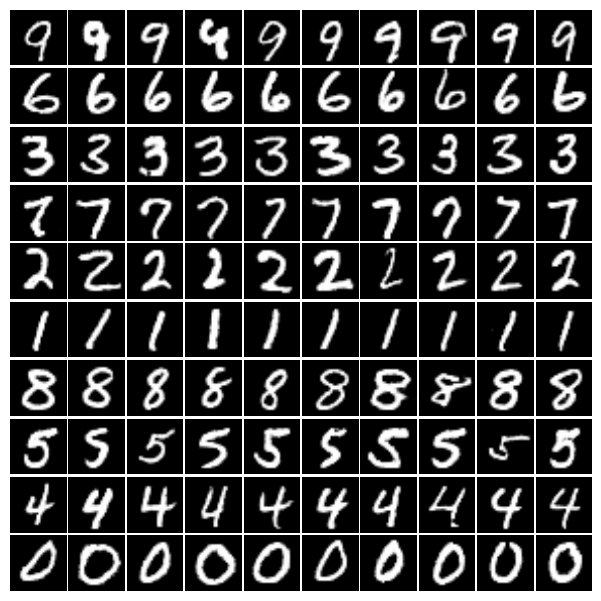

[24001/30000] D_loss: 0.4355 | G_loss: 3.2847 | Q_loss: 0.1912


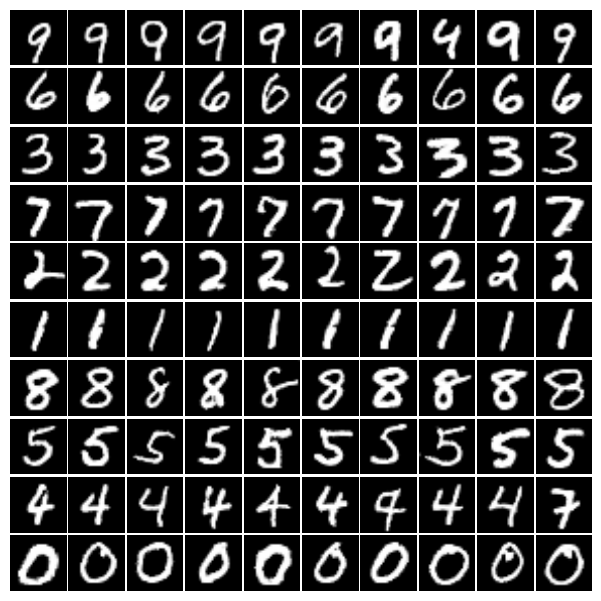

[25001/30000] D_loss: 0.2820 | G_loss: 3.4406 | Q_loss: 0.1513


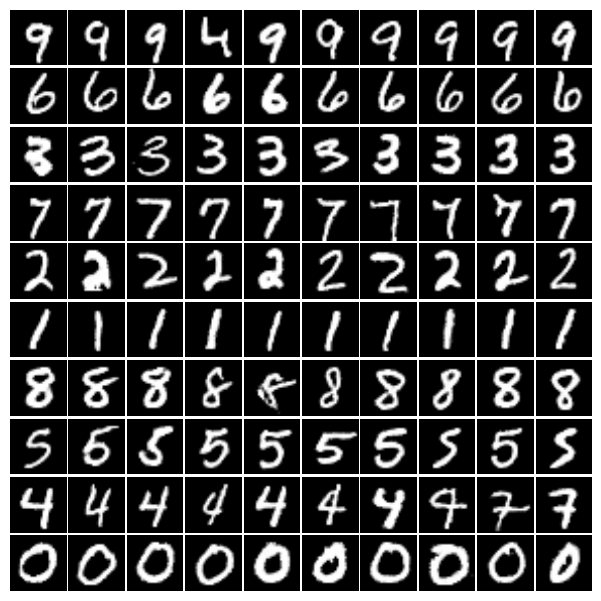

[26001/30000] D_loss: 0.3484 | G_loss: 3.3172 | Q_loss: 0.1759


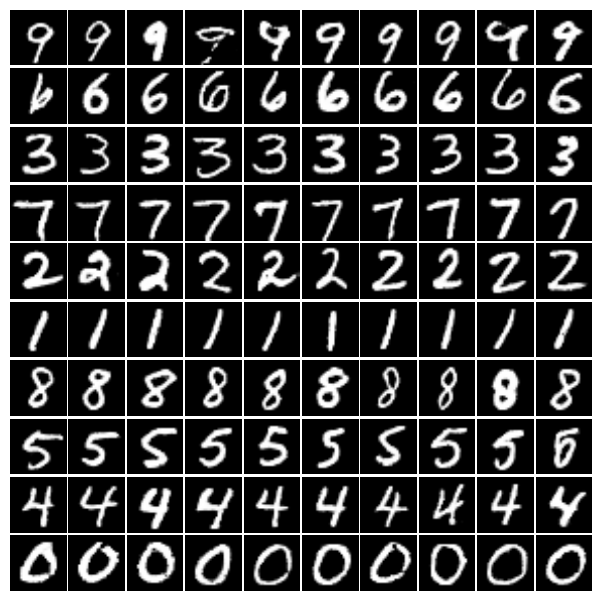

[27001/30000] D_loss: 0.2998 | G_loss: 3.5533 | Q_loss: 0.1805


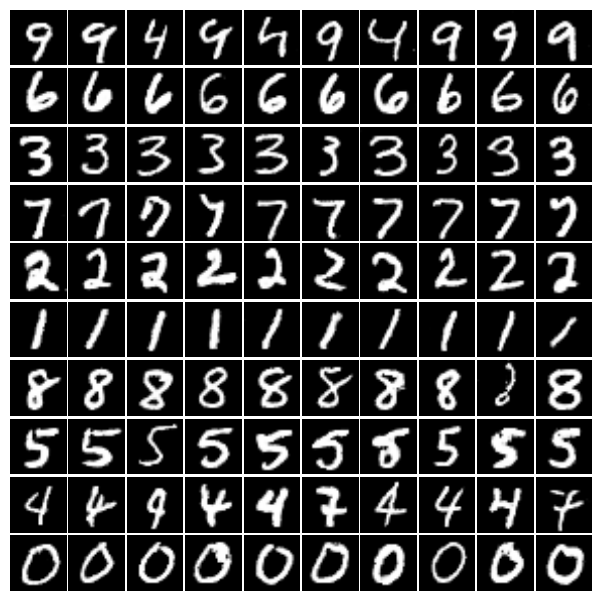

[28001/30000] D_loss: 0.3269 | G_loss: 3.4529 | Q_loss: 0.1745


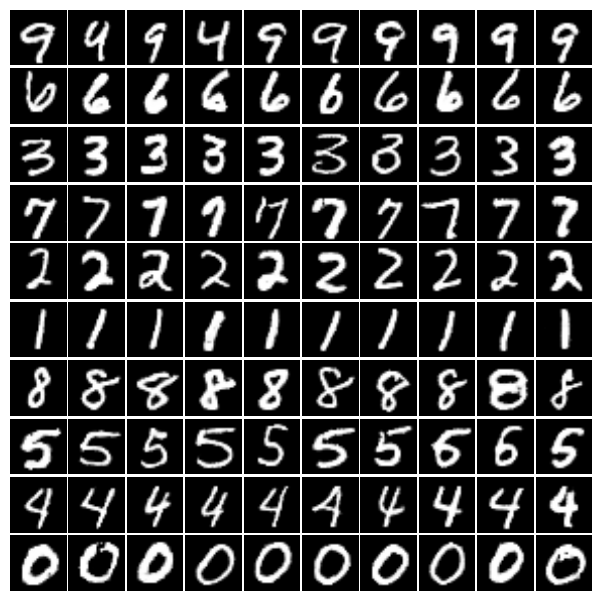

[29001/30000] D_loss: 0.2785 | G_loss: 3.2241 | Q_loss: 0.1713


In [15]:
batch_size = 128
n_iter = 30000
print_step = 1000

sess = tf.Session()
sess.run(tf.global_variables_initializer())
# writer = tf.summary.FileWriter("./tmp/", sess.graph)

for i in range(n_iter):
    if i % print_step == 0:
        plot_100()
        plt.show()
    
    batch_x, _ = mnist.train.next_batch(batch_size)
    z_ = sample_z(batch_size)
    c_ = sample_c(batch_size)
    
#     _, D_loss_cur, summary_cur = sess.run([D_train_op, D_loss, summary_op], {X: batch_x, z: z_, c: c_, training: True})
#     # G+Q 해도 될거 같은데?
#     _, G_loss_cur = sess.run([G_train_op, G_loss], {z: z_, c: c_, training: True})
#     _, Q_loss_cur = sess.run([Q_train_op, Q_loss], {z: z_, c: c_, training: True})
    # single-step training
    _, _, _, D_loss_cur, G_loss_cur, Q_loss_cur = sess.run([D_train_op, G_train_op, Q_train_op, D_loss, G_loss, Q_loss],
                                                           {X: batch_x, z: z_, c: c_, training: True})
    
    if i % print_step == 0:
        print('[{}/{}] D_loss: {:.4f} | G_loss: {:.4f} | Q_loss: {:.4f}'.
              format(i+1, n_iter, D_loss_cur, G_loss_cur, Q_loss_cur))

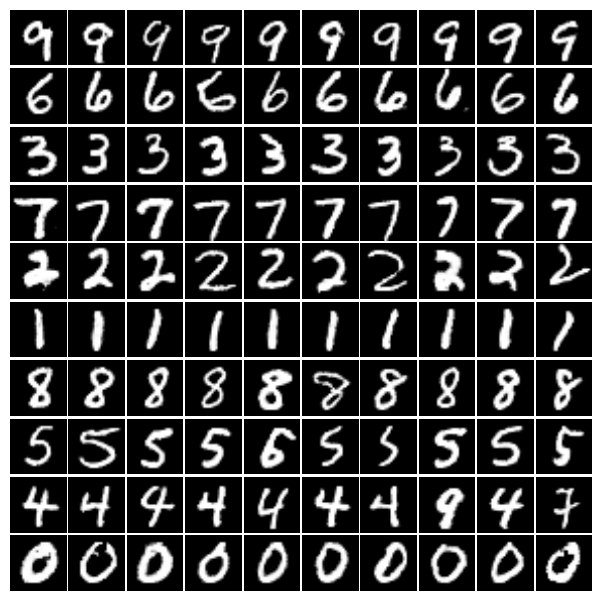

In [16]:
plot_100()

In [17]:
increments = np.tile(np.linspace(-2, 2, 10), 10).reshape(-1, 1)
zeros = np.zeros([100, 1])

In [18]:
increments.shape, zeros.shape

((100, 1), (100, 1))

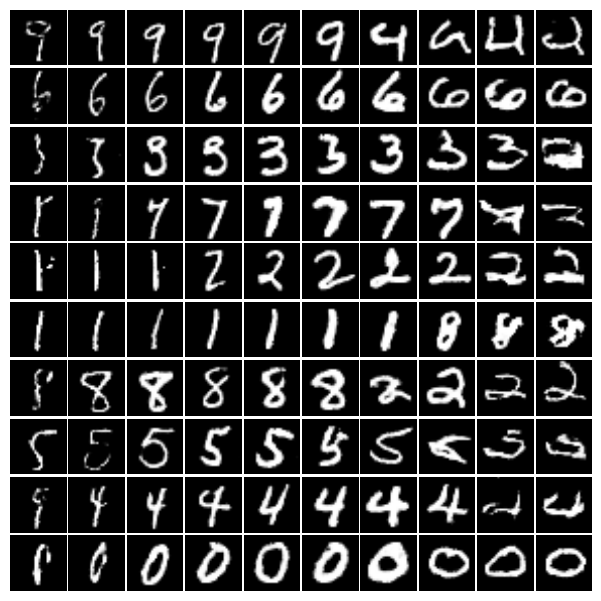

In [19]:
c_cont = np.concatenate([increments, zeros], axis=1)
plot_100(c_cont=c_cont)

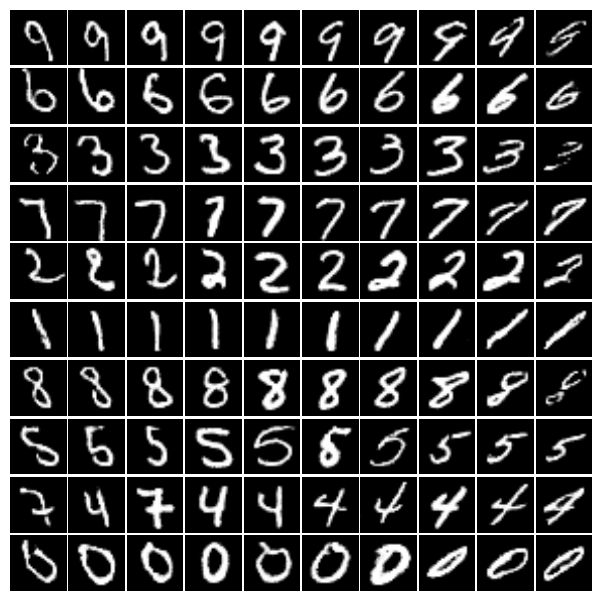

In [20]:
c_cont = np.concatenate([zeros, increments], axis=1)
plot_100(c_cont)

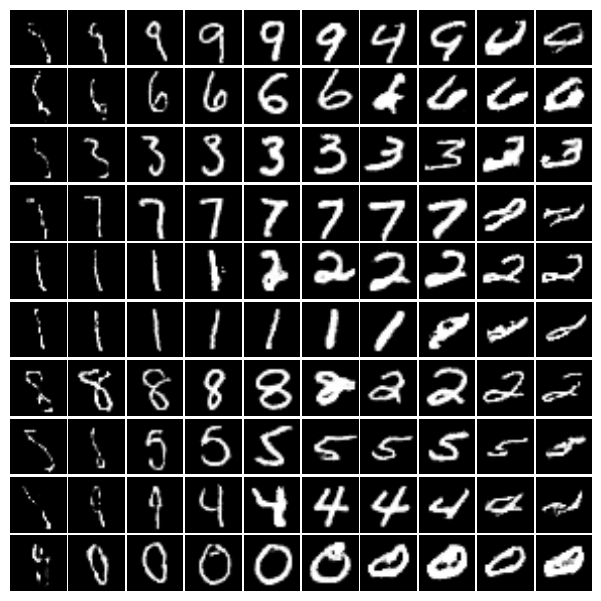

In [21]:
c_cont = np.concatenate([increments, increments], axis=1)
plot_100(c_cont)